In [22]:
SEED = 42
from random import seed as py_seed
py_seed(SEED)
from numpy.random import seed as np_seed
np_seed(SEED)
from tensorflow import random as tf_random
tf_random.set_seed(SEED)

In [23]:
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Activation, GlobalAveragePooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils import np_utils
from keras.models import load_model
from keras.applications.mobilenet import MobileNet
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.nasnet import NASNetMobile
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pathlib import Path
import random
from sklearn.model_selection import KFold, train_test_split
from keras import backend as K
import keras
import tensorflow as tf
import functools

In [24]:
# Data comes from here. This should contain a bunch of folders of classes, each containing examples
#DATA_PATH = Path('food-101-original-source/images')
DATA_PATH = Path('food-101/images')

# Get class (folder) names
classes = sorted([entry.name for entry in DATA_PATH.iterdir() if entry.is_dir()])

SPLIT = 25
random.shuffle(classes) # shuffle the classes 
classes = classes[:SPLIT]
classes = sorted(classes)
# Load list of filenames and classes, and convert to numpy array to allow array slicing
# For k-fold validation
dataset = np.array([
    (f"{clazz}/{entry.name}", clazz)
    for clazz in classes
    for entry in (DATA_PATH / clazz).iterdir()
])

In [25]:
# Randomly selected classes 
print(classes)

['baby_back_ribs', 'breakfast_burrito', 'bruschetta', 'ceviche', 'chocolate_cake', 'deviled_eggs', 'dumplings', 'filet_mignon', 'french_onion_soup', 'french_toast', 'frozen_yogurt', 'greek_salad', 'grilled_salmon', 'huevos_rancheros', 'hummus', 'nachos', 'paella', 'panna_cotta', 'peking_duck', 'pork_chop', 'prime_rib', 'ramen', 'spring_rolls', 'steak', 'takoyaki']


In [26]:
# create data generators

# Rescale 0-255 to 0-1
RESCALE=1./255

# This type of data generator is used to train the model
train_datagen = ImageDataGenerator(
    rescale=RESCALE,
    # Factors used to control
    rotation_range=45,  # randomly rotate images in the range (degrees, 0 to 180)
    width_shift_range=0.125,  # randomly shift images horizontally (fraction of total width)
    height_shift_range=0.125,  # randomly shift images vertically (fraction of total height)
    horizontal_flip=True,  # randomly flip images

)

# This type of generator is used to test the model
test_datagen = ImageDataGenerator(
    rescale=RESCALE,
)




### Function for Top 10 accuracy

In [27]:
top10_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=10)

top10_acc.__name__ = 'top10_acc'

In [28]:
def create_model(input_shape, num_classes):
    
    # Base model, with weights pre-trained on ImageNet.
    base_model = NASNetMobile(input_shape, weights='imagenet', include_top=False)

    for layer in base_model.layers:
        layer.trainable = False

    model = Sequential()
    model.add(base_model)
    model.add(GlobalAveragePooling2D())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    optimizer = RMSprop()

    model.compile(
        loss = 'categorical_crossentropy',
        optimizer = optimizer,
        metrics = ['accuracy', 'top_k_categorical_accuracy',top10_acc]  # top1, top5 and top10 accuracies
    )
    
    return model

In [29]:
# Image data generator settings
TARGET_SIZE = (224,224)
COLOR_MODE = "rgb"
BATCH_SIZE = 64
CLASS_MODE = "categorical"


# Training settings
NUM_FOLDS = 5
VALIDATION_SPLIT = 0.1
NUM_EPOCHS = 5

# Create train and test dataset
d_train, d_test = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# Extract train dataset
#d_train = dataset[train_index]
# Split train dataset to form train and validation dataset
d_train, d_val = train_test_split(dataset, test_size = VALIDATION_SPLIT)

# These are used to convert the filename,class pairs to dataframes
FILENAME_COL = "filename"
CLASS_COL = "class"
COLUMNS = [FILENAME_COL, CLASS_COL]
# Convert to dataframes
d_train = pd.DataFrame(d_train, columns = COLUMNS)
d_val = pd.DataFrame(d_val, columns = COLUMNS)

# Create training data generators
# Training image data generator
train_it = train_datagen.flow_from_dataframe(
    d_train,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = True,
    seed = SEED
)
# Validation image data generator
val_it = test_datagen.flow_from_dataframe(
    d_val,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)

# Perform training
# Build the model
input_shape = (*TARGET_SIZE,3)
num_classes = len(classes)
model = create_model(input_shape, num_classes)

# Train the model
history = model.fit(
    train_it,
    validation_data=val_it,
    epochs=NUM_EPOCHS,
    workers=6,
    max_queue_size=100,
    verbose=True
)



Found 22500 validated image filenames belonging to 25 classes.
Found 2500 validated image filenames belonging to 25 classes.
Epoch 1/5
352/352 [==============================] - 730s 2s/step - loss: 2.5779 - accuracy: 0.2599 - top_k_categorical_accuracy: 0.5864 - top10_acc: 0.7727 - val_loss: 1.9729 - val_accuracy: 0.3868 - val_top_k_categorical_accuracy: 0.7732 - val_top10_acc: 0.9064
Epoch 2/5
352/352 [==============================] - 692s 2s/step - loss: 2.0828 - accuracy: 0.3849 - top_k_categorical_accuracy: 0.7431 - top10_acc: 0.8884 - val_loss: 2.3102 - val_accuracy: 0.4004 - val_top_k_categorical_accuracy: 0.7836 - val_top10_acc: 0.9116
Epoch 3/5
352/352 [==============================] - 704s 2s/step - loss: 1.9629 - accuracy: 0.4190 - top_k_categorical_accuracy: 0.7733 - top10_acc: 0.9054 - val_loss: 2.1227 - val_accuracy: 0.4280 - val_top_k_categorical_accuracy: 0.7960 - val_top10_acc: 0.9232
Epoch 4/5
352/352 [==============================] - 714s 2s/step - loss: 1.9197 - 

In [30]:
model.save("model-25.h5")

In [31]:
d_test = pd.DataFrame(d_test, columns = COLUMNS)

# Extract test dataset and convert to dataframe
#d_test = pd.DataFrame(dataset[test_index], columns = COLUMNS)
# Create test image data generator
test_it = test_datagen.flow_from_dataframe(
    d_test,
    directory = DATA_PATH,
    x_col = FILENAME_COL,
    y_col = CLASS_COL,
    target_size = TARGET_SIZE,
    color_mode = COLOR_MODE,
    batch_size = BATCH_SIZE,
    class_mode = CLASS_MODE,
    shuffle = False,
)


Found 2500 validated image filenames belonging to 25 classes.


In [32]:
# Test
loss, accuracy, top5acc, top10acc = model.evaluate(test_it)

print(f"Test Accuracy Top-1: {accuracy * 100}%, Top-5: {top5acc * 100}%, Top-10: {top10acc * 100}%")

40/40 [==============================] - 59s 1s/step
Test Accuracy Top-1: 45.39999961853027%, Top-5: 81.27999901771545%, Top-10: 93.0400013923645%


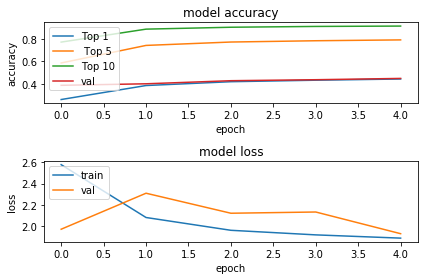

In [33]:
plt.figure(1)

# summarize history for accuracy
plt.subplot(211) 
plt.plot(history.history['accuracy']) 
plt.plot(history.history['top_k_categorical_accuracy'])
plt.plot(history.history['top10_acc'])
plt.plot(history.history['val_accuracy']) 
plt.title('model accuracy') 
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Top 1', ' Top 5','Top 10' , 'val'], loc='upper left')

# summarize history for loss
plt.subplot(212) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss']) 
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.tight_layout() 
plt.savefig('acc_loss_50.pdf')
plt.show()